# Chapter 7: Moving beyond linearity

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score
from pygam import LinearGAM, s, l 


from sklearn.model_selection import train_test_split

### 10. This question relates to the College data set.


        
        

In [3]:
data=pd.read_csv('../Data/College.csv')
data['Private']=data.Private.map(dict(Yes=1, No=0))
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.rename(columns={
    "F.Undergrad": "F_Undergrad",
    "P.Undergrad": "P_Undergrad",
    "Room.Board": "RoomBoard",
    "S.F.Ratio": "S_F_Ratio",
    "perc.alumni": "PercAlumni",
    "Grad.Rate": "GradRate"}, errors="raise", inplace=True)

data.head(1000)


,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,RoomBoard,Books,Personal,PhD,Terminal,S_F_Ratio,PercAlumni,Expend,GradRate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,0,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,1,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,1,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,1,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


 **(a) Split the data into a training set and a test set. Using out-of-state
        tuition as the response and the other variables as the predictors,
        perform forward stepwise selection on the training set in order
        to identify a satisfactory model that uses just a subset of the
        predictors.**

There is no official implementation for stepwise regression in python and it's popular libraries. Therefore instead of having to write the full algorithm I decided to use the lasso model which automatically shrinks the linear model and performs feature selection.

In [4]:
#Normalizing data
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])

Y=data['Outstate']
X=data.loc[:, data.columns != 'Outstate']

#Split into training/test set
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=2)


In [5]:
#Compute predictors to drop
lasso_regr=LassoCV(cv=5).fit(X_train, y_train) # 5-folds cv to choose tuning param for lasso
lassoPredictorsToDrop = X_train.columns[lasso_regr.coef_ == 0]
print("Drop predictors: "+ str(lassoPredictorsToDrop))

Drop predictors: Index(['Apps', 'Enroll', 'P_Undergrad', 'Books'], dtype='object')


In [6]:
for pred in lassoPredictorsToDrop:
    X_train = X_train[X_train.columns[X_train.columns != str(pred)]]
    X_test = X_test[X_test.columns[X_test.columns != str(pred)]]
X_train.head()

,Private,Accept,Top10perc,Top25perc,F_Undergrad,RoomBoard,Personal,PhD,Terminal,S_F_Ratio,PercAlumni,Expend,GradRate
530,0.0,0.068474,0.178947,0.373626,0.203593,0.277427,0.290076,0.705263,0.684211,0.391421,0.125000,0.051464,0.324074
565,0.0,0.170767,0.168421,0.670330,0.215973,0.477617,0.190840,0.642105,0.802632,0.522788,0.328125,0.039474,0.490741
745,0.0,0.059068,0.063158,0.164835,0.069071,0.311318,0.274809,0.715789,0.723684,0.453083,0.062500,0.026637,0.388889
123,1.0,0.092162,0.473684,0.725275,0.079672,0.596627,0.076336,0.915789,0.973684,0.214477,0.703125,0.232021,0.768519
322,1.0,0.046119,0.200000,0.329670,0.048375,0.349937,0.145038,0.557895,0.500000,0.313673,0.375000,0.082795,0.555556


In [98]:
# Now that the lasso has selected a subset of our predictors, we can fit a regular linear regression model
regr = LinearRegression().fit(X_train,y_train) #Ordinary least squares Linear Regression.
y_predicted= regr.predict(X_test)
r2 = r2_score(y_test, y_predicted)
#We can use R2 as score since the GAM model in the next step will have the same amount of variables
print("R2: "+str(r2)) 

R2: 0.7484060059753802


    (b) Fit a GAM on the training data, using out-of-state tuition as
        the response and the features selected in the previous step as
        the predictors. Plot the results, and explain your findings.


In [8]:
dfTrain=pd.concat([X_train, y_train], axis=1, sort=False)
dfTest=pd.concat([X_test,y_test], axis=1, sort=False)
dfTest.head(1000)

,Private,Accept,Top10perc,Top25perc,F_Undergrad,RoomBoard,Personal,PhD,Terminal,S_F_Ratio,PercAlumni,Expend,GradRate,Outstate
624,0.0,0.215363,0.221053,0.450549,0.424676,0.521438,0.454656,0.778947,0.789474,0.201072,0.093750,0.201651,0.222222,0.252583
157,1.0,0.016604,0.115789,0.230769,0.010189,0.497163,0.038168,0.557895,0.486842,0.528150,0.156250,0.102871,0.574074,0.514050
174,1.0,0.145518,0.936842,0.978022,0.192007,0.657314,0.139237,0.915789,0.947368,0.067024,0.687500,0.452806,0.805556,0.839360
109,1.0,0.006931,0.252632,0.604396,0.012030,0.509931,0.091603,0.663158,0.618421,0.155496,0.453125,0.085641,0.583333,0.412965
20,1.0,0.022431,0.252632,0.384615,0.018188,0.245271,0.129771,0.642105,0.763158,0.235925,0.546875,0.749147,0.351852,0.678512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,1.0,0.106977,0.736842,0.923077,0.182263,0.843474,0.221374,0.873684,0.894737,0.126005,0.421875,0.310084,0.787037,0.824380
399,1.0,0.015729,0.178947,0.296703,0.030948,0.246847,0.053435,0.515789,0.434211,0.463807,0.109375,0.069429,0.444444,0.261364
12,1.0,0.026963,0.389474,0.604396,0.031456,0.473676,0.114504,0.547368,0.789474,0.289544,0.328125,0.089619,0.592593,0.379649
171,1.0,0.095247,0.347368,0.615385,0.101035,0.471311,0.217557,0.842105,0.907895,0.335121,0.375000,0.118518,0.620370,0.572314


Now we can construct the GAM model. Using the statsmodels library we can fit a GAM with B-splines. I did not really understand what kind of splines these are from reading the document, but presumably they are closely related to smoothing splines which the book is covering. We also need to choose the DoF, polynomial degree and alpha for each B-spline which will affect the smoothness. These could ideally be choosen by CV but I never managed to do that, so I choose cubic splines with a DoF of 10 and alpha of 0.005 for each spline after some experimentation. This is not ideal but needed for simplicity. One could also try different models by hand by comparing the score, but it is not a very good way of doing it either.

In [9]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

In [10]:
bs = BSplines(X_train, df=[10 for i in range(0,13)], degree=[3 for i in range(0,13)],constraints=None)
alpha = [0.005 for i in range(0,13)]
gam_bs = GLMGam.from_formula('Outstate ~ Private : GradRate', data=dfTrain, smoother=bs, alpha=alpha).fit()


In [11]:
print(gam_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Outstate   No. Observations:                  520
Model:                         GLMGam   Df Residuals:                   474.72
Model Family:                Gaussian   Df Model:                        44.28
Link Function:               identity   Scale:                       0.0083270
Method:                         PIRLS   Log-Likelihood:                 530.79
Date:                Thu, 09 Apr 2020   Deviance:                       3.9530
Time:                        10:44:29   Pearson chi2:                     3.95
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0579      0.108  

We can also do the paritial dependence plot for the GAM:

<Figure size 432x288 with 0 Axes>

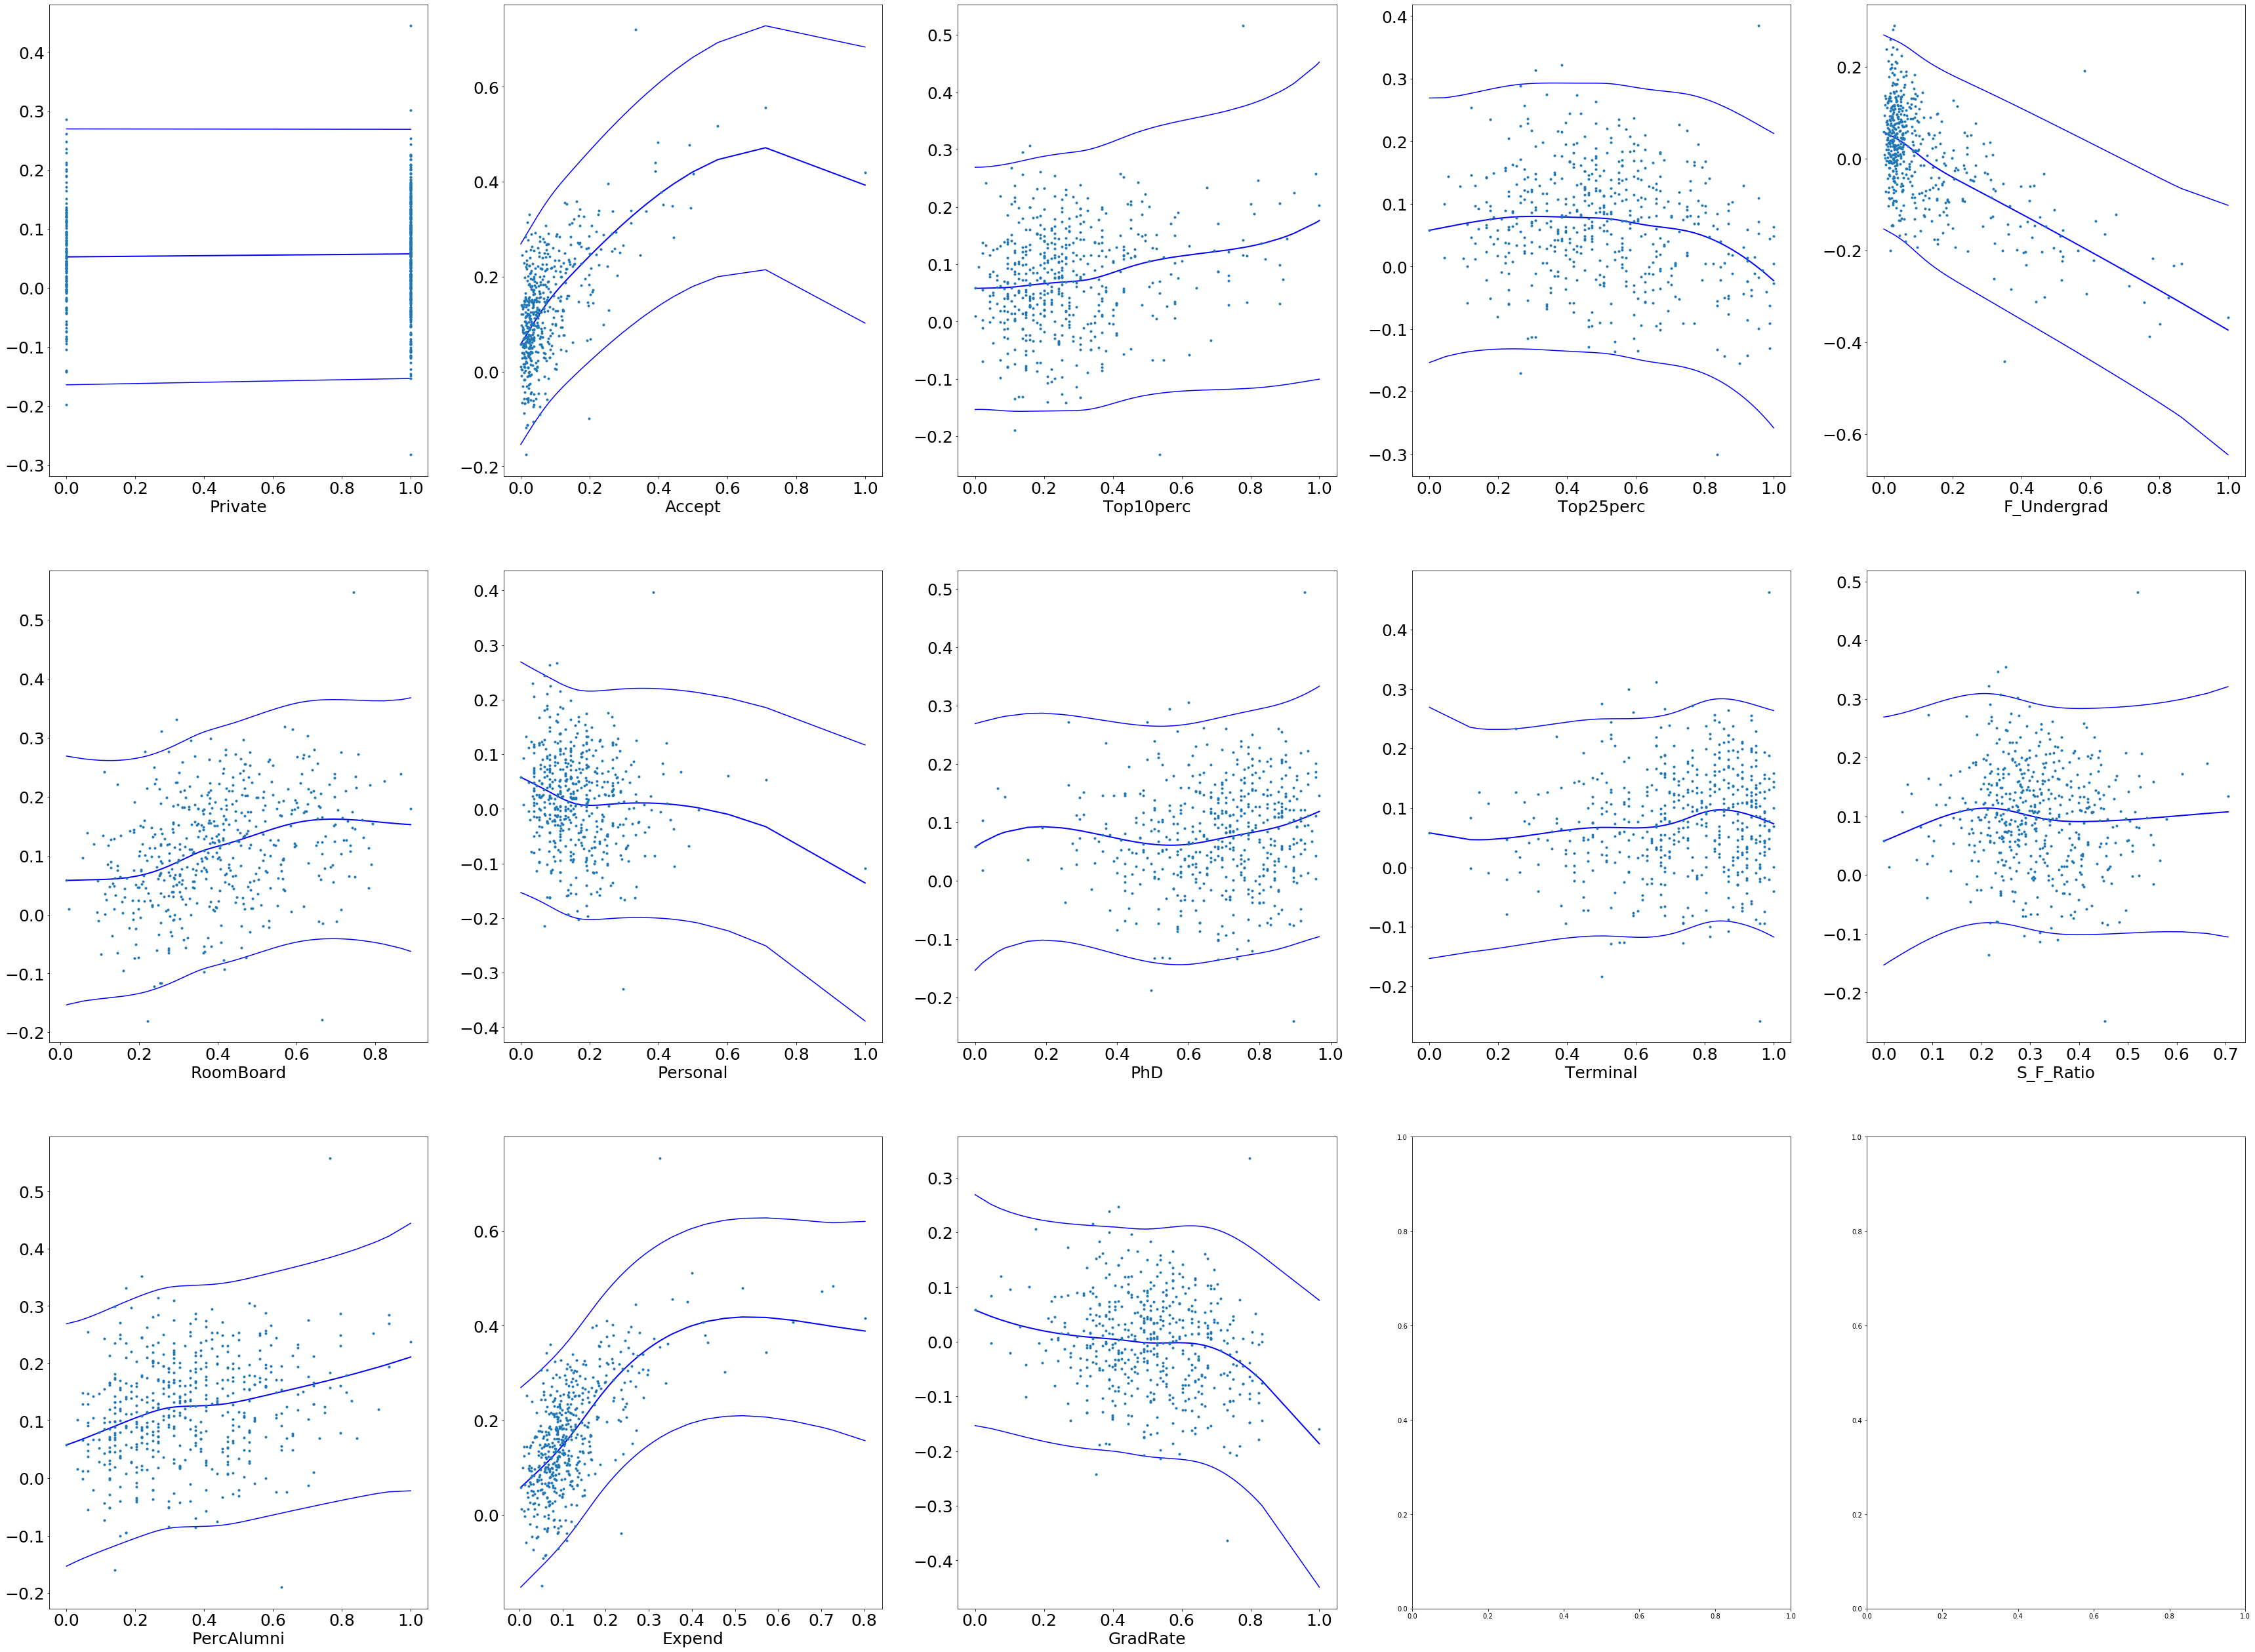

In [12]:
plt.figure();
fig, axrows = plt.subplots(3,5,figsize=(60, 45));

nFeatures = 13
i=0
plt.rcParams.update({'font.size': 12})
for axrow in axrows:
    for ax in axrow:
        gam_bs.plot_partial(i, cpr=True, ax=ax)
        
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(25)
        
        i=i+1
        if i == nFeatures:
            break


We can see that there is no clear trend in many of the dependence plots, but that the splines still manages to form some kind of relationship in the data for some of the variables. Let's test how it performs.

    (c) Evaluate the model obtained on the test set, and explain the
        results obtained.



After very much testing I never managed to use the model to predict as I was getting errors. It was quite frustrating since there were not much documentation to find online regarding these issues that I had, and the available documentation was hard to understand. I spent a lot of time trying to find ways to answer this question but was unable to finish, as I realized I also have to study for other courses as well.

I ended up starting over by using another library called pyGAM, but encountered some other problems there which I will cover later.

    (d) For which variables, if any, is there evidence of a non-linear
        relationship with the response?

I would say from the partial dependence plots it either looks like there is no relationship at all or a small linear one. The fitted model's t-values for each variable also tells us that Accept and Expend are the most significant variables, and it seems like they both might have a non-linear relationship with the response if one takes a look at the splines.



Now, below is how I used pyGAM to fit a GAM instead once I realized I could not figure out how to make predictions with the previous library.

In [45]:
from pygam import LinearGAM, s, f

## model
gam = LinearGAM(
                s(0) +
                s(1) + 
                s(2) + 
                s(3) + 
                s(4) + 
                s(5) + 
                s(6) + 
                s(7) +
                s(8) + 
                s(9) + 
                s(10) +
                s(11) + 
                s(12)   
                ).fit(X_train,y_train)
#GridSearch optimizes the smoothing parameters using Generalied Cross Validation
gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    118.0865
Link Function:                     IdentityLink Log Likelihood:                                -23987.3869
Number of Samples:                          520 AIC:                                            48212.9467
                                                AICc:                                           48284.4655
                                                GCV:                                                0.0128
                                                Scale:                                              0.0077
                                                Pseudo R-Squared:                                    0.864
Feature Function                  Lam

/Users/antonclaesson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



In [46]:
print(gam.statistics_['edof'])

118.08645908555523


We can see that there is a total of (5 + 12*20) = 245 free variables for the 13 terms, but that the default smoothing parameter of lambda = 0.6 reduces the effective degree of freedom to ≈118.

By default the spline terms use 20 basis functions which I also decided to use in the next part, but it can easily be customized by setting a parameter in the spline terms (The s() in the model above). This is quite high but it could be a good idea to use a high number of basis functions and let the smoothing penalty regularize the model.

The splines have a smoothing penalty on their 2nd derivative by default.
One can also fit linear terms or factor terms instead of spline terms in the model, but I will just fit using splines for simplicity.

To choose better lambdas we can use a function called gridsearch which optimizes over a span of given paramters using Generalized Cross Validation. We will try a randomized number of lambda values.

In [53]:
lams = np.random.rand(300, 13) # 300 random points on [0, 1], shape (300, 13)
lams = lams * 10 - 5 # shift values to -5, 5
lams = np.exp(lams) # transforms values to 1e-5, 1e5 (from around 0 to around 148)

random_gam =  LinearGAM(
                s(0) +
                s(1) + 
                s(2) + 
                s(3) + 
                s(4) + 
                s(5) + 
                s(6) + 
                s(7) +
                s(8) + 
                s(9) + 
                s(10) +
                s(11) + 
                s(12)   
                ).gridsearch(X_train.to_numpy(), y_train.to_numpy(), lam=lams, objective='GCV')
random_gam.summary()

100% (300 of 300) |######################| Elapsed Time: 0:00:33 Time:  0:00:33


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     78.3534
Link Function:                     IdentityLink Log Likelihood:                                -26527.1845
Number of Samples:                          520 AIC:                                            53213.0757
                                                AICc:                                           53242.0822
                                                GCV:                                                0.0105
                                                Scale:                                              0.0077
                                                Pseudo R-Squared:                                   0.8504
Feature Function                  Lam

/Users/antonclaesson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



In [54]:
print(random_gam.statistics_['edof'])

78.35337177910185


We can see that the smoothing parameters chosen by GCV now reduces the effective DoF to just ≈78, and also provides better R-squared and GCV score. We can also plot the partial dependence funtions:

<Figure size 432x288 with 0 Axes>

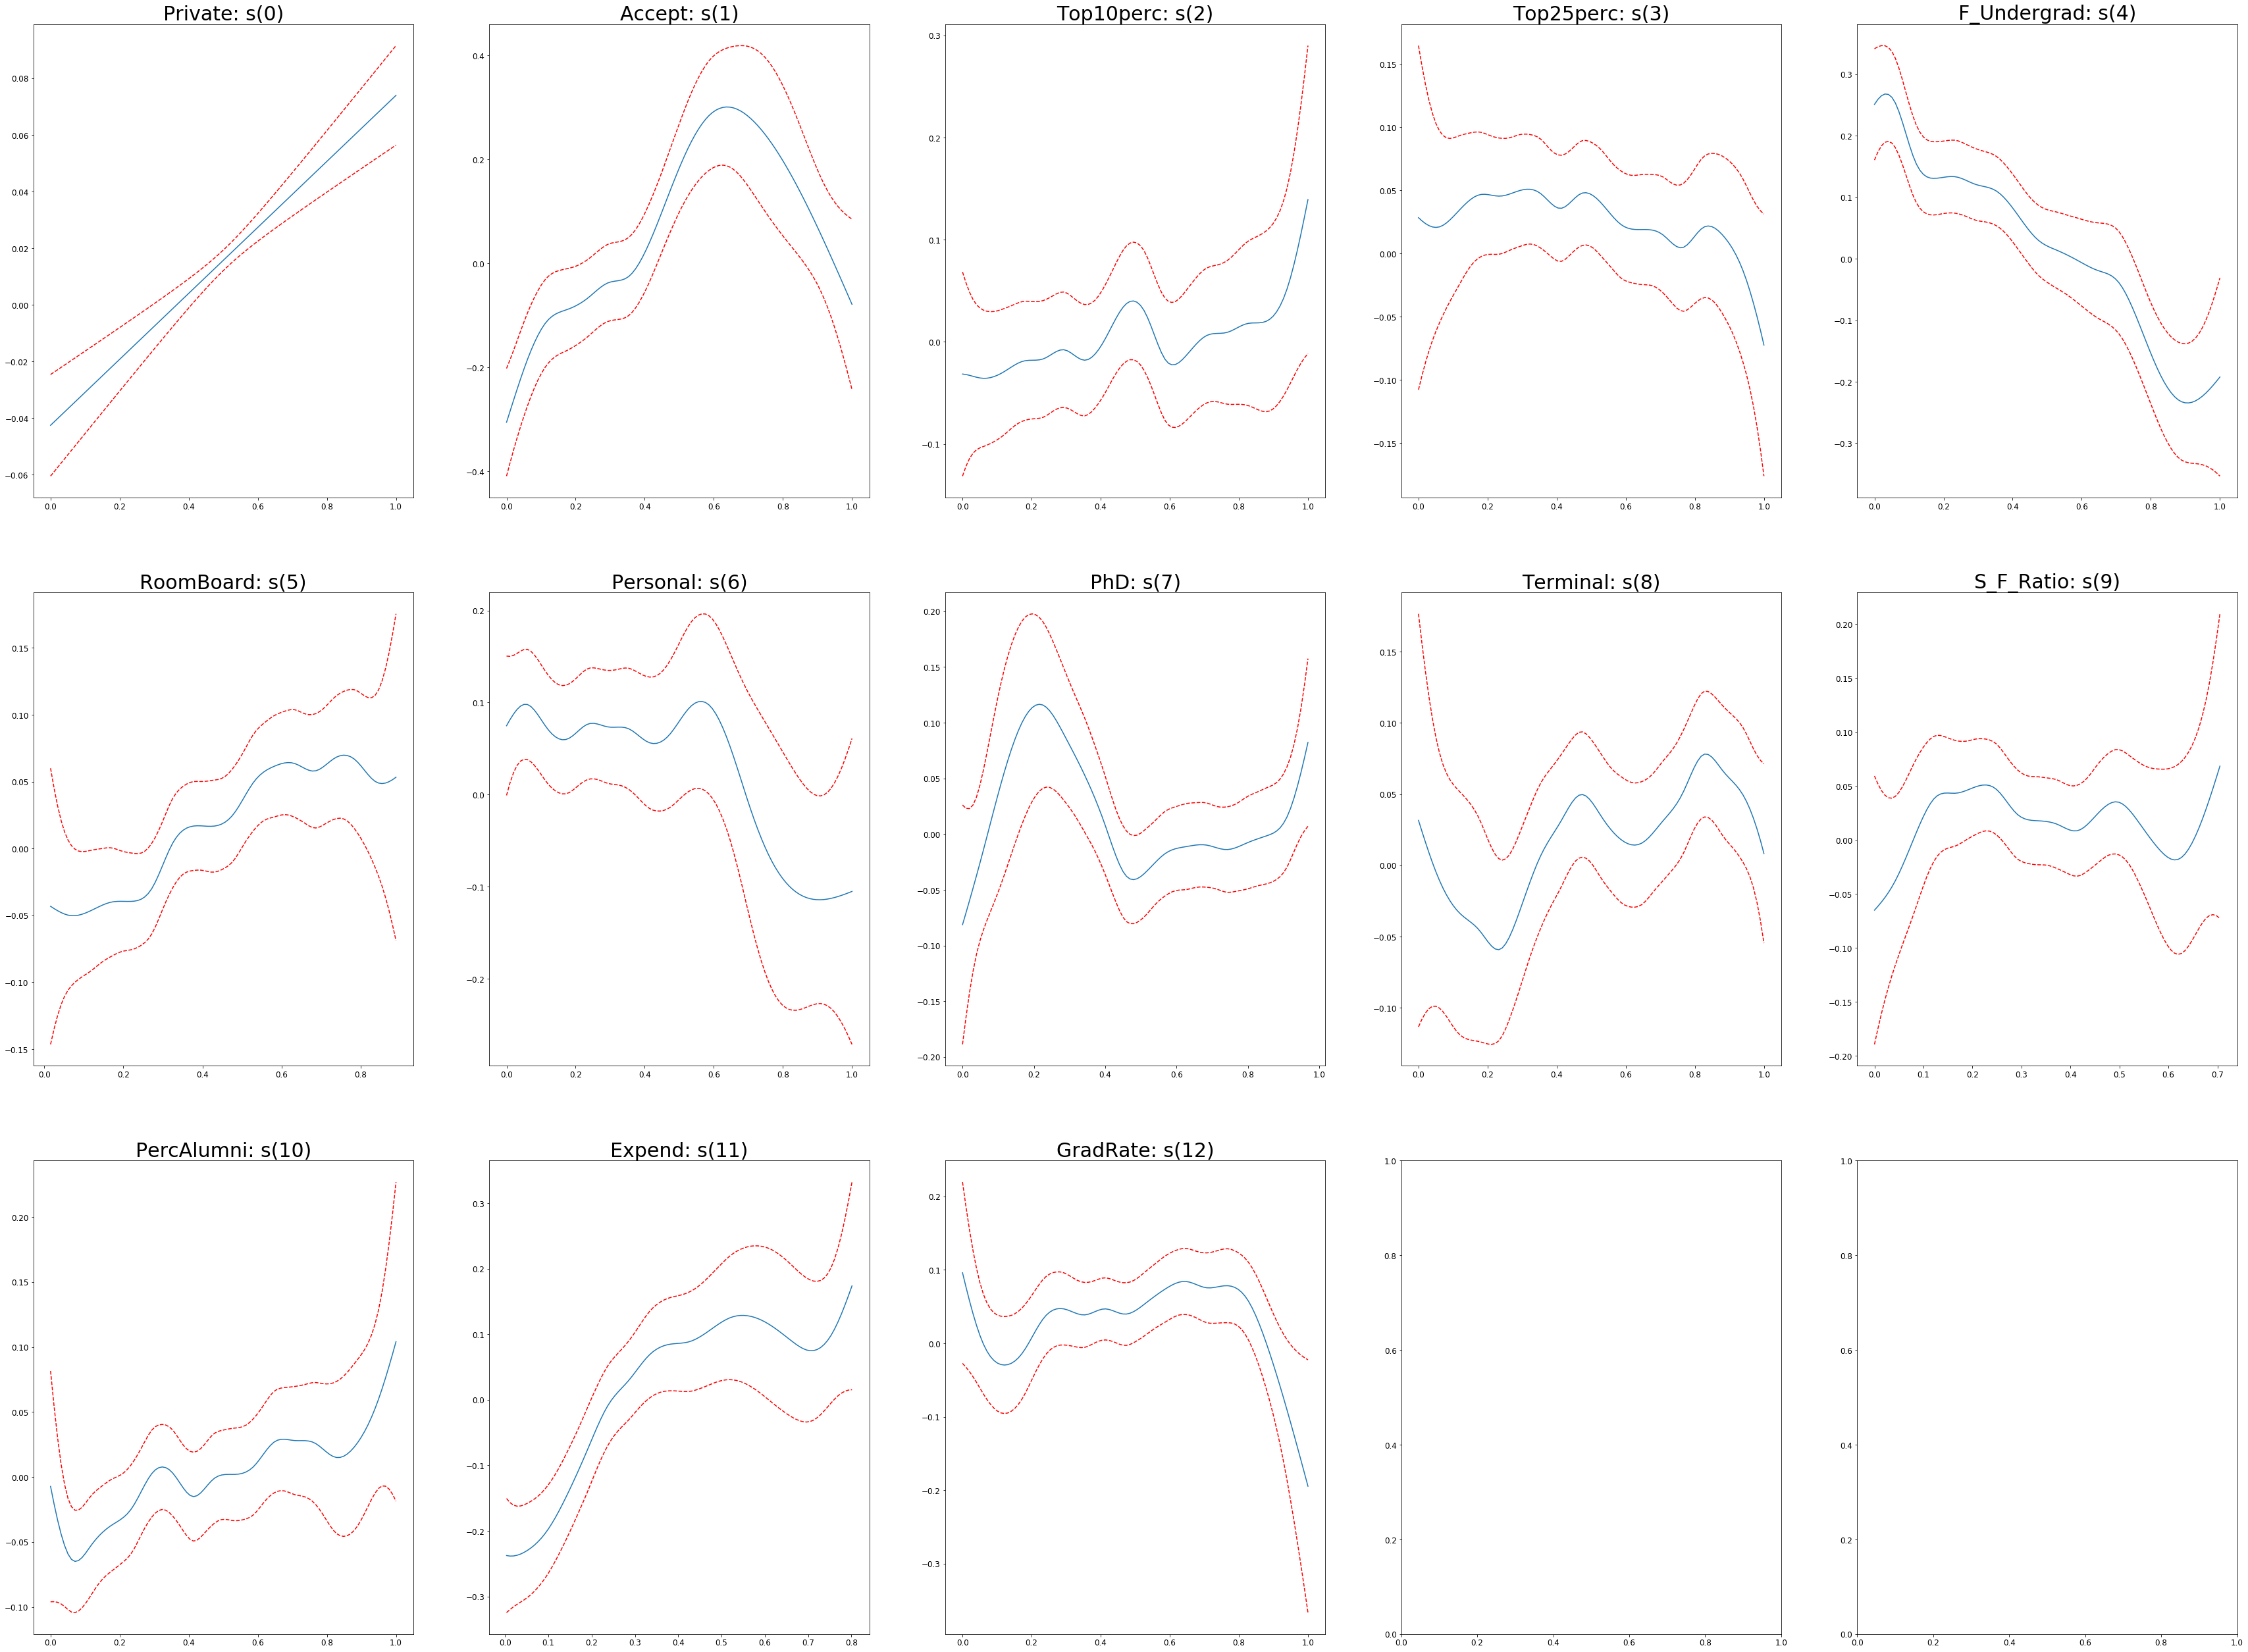

In [85]:
plt.figure();
fig, axrows = plt.subplots(3,5,figsize=(60, 45));

titles=X_train.columns
terms = random_gam.terms
i=0
for axrow in axrows:
    for ax in axrow:
        if not terms[i].isintercept:
            name = titles[i]
            term = terms[i]
            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
            ax.set_title(name+": "+repr(term),fontsize=30)
            i=i+1
       
plt.show()

We can see that the splines are quite flexible, especially at the end points, and maybe the model will suffer from overfitting? We will try to validate with the test set. Ideally one could probably set constraints to reduce the variance in the end points, but I did not have more time to try that.

Here I would want to perform a scatterplot of the data points as well, but the data seems to have been scaled for the partial dependence plot, and I was unable to figure out how to do the correct plot so I ommited that. Unfortunately this leads to having a harder time to interpret the plots. 

In [100]:
y_predicted = random_gam.predict(X_test)
r2=r2_score(y_test, y_predicted)
print("R2:" + str(r2))

R2:0.7771968765352364


The linear model had a R2 of 0.748 on the test set while the GAM has an R2 of 0.77 which is a small improvement.
The GAM had a R2 on the training data of 0.85 which is higher than for the test data and also expected. To further make improvements one might be able to do best-subset selection or similar using different parameters or tune the spline basis functions, but that is too much for this week and as I said before there is no finished library implementation of that in python.